### Optical waveguides

Define function to plot Bessel function of the first kind of order m, and mark the first zero.

In [18]:
import numpy as np
from scipy import special
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import FormatStrFormatter

def Bessel_plotter(m, n):
    # set up latex labels on plot (optional)
    try:
        rc('text', usetex=True) # can try usetex=False
        rc('font', size=14)
        rc('legend', fontsize=14)
        rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    except:
        pass    
    
    # create figure
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # set axis labels and limits
    ax.set_xlabel(r'$x_{cut}$')
    ax.set_ylabel(r'$J_{:.0f}\!\;\!\,(x)$, $J_{:.0f}\!\,^\prime(x)$'.format(m, m))

    ## TE modes
    # plot derivative of Bessel function of first kind and m'th order
    x = np.linspace(0, 40, 1000, endpoint=True)
    ax.plot(x, special.jvp(m, x), 'b', label='TE$\!\;\!\,_{}$$_{}$ mode'.format(m,n))
    
    # plot n'th zero of derivative of Bessel function
    ax.plot(special.jnp_zeros(m, n)[-1], 0, 'gx')
    
    ## TM modes
    # plot Bessel function of first kind and m'th order
    x = np.linspace(0, 40, 1000, endpoint=True)
    ax.plot(x, special.jv(m, x), 'r', label='TM$_{}$$_{}$ mode'.format(m,n))
    
    # plot n'th zero of Bessel function
    ax.plot(special.jn_zeros(m, n)[-1], 0, 'gx')
    
    ax.legend()
    
    plt.show()

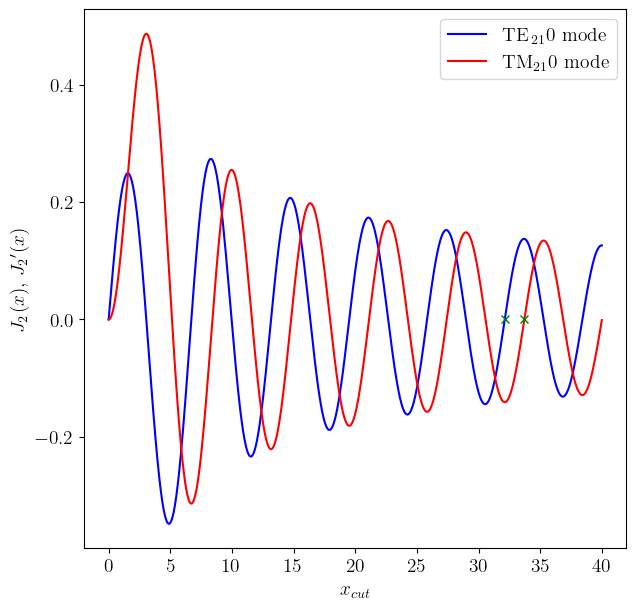

In [19]:
Bessel_plotter(2, 10)

Define functions to calculate the cut-off wavelengths in an optical/circular waveguide.

In [3]:
def TE_cutoff(m, n, radius):
    # find n'th root of derivative of Bessel function of the first kind and m'th order
    root = special.jnp_zeros(m, n)[-1]
    
    # find the cut-off wavenumber
    kc = root/radius
    
    return 2*np.pi/kc

def TM_cutoff(m, n, radius):
    # find n 'th' root of Bessel function of the first kind and m'th order
    root = special.jn_zeros(m, n)[-1]
    
    # find the cut-off wavenumber
    kc = root/radius
    
    return 2*np.pi/kc

In [28]:
print(TE_cutoff(0, 1, 1))
print(TM_cutoff(0, 1, 1))

1.6397879576441796
2.612740573665532


Define function to calculate the wavelength along the optical waveguide.

In [29]:
def guide_wavelength(frequency, kappa_e, cutoff_wavelength):
    # test if wavelength is greater than cut-off wavelength
    if kappa_e*frequency**2/3e8**2 - 1./cutoff_wavelength**2 > 0:
        return 1./np.sqrt(kappa_e*frequency**2/3e8**2 - 1./cutoff_wavelength**2)
    else:
        raise Exception('Wavelength less than cut-off wavelength.')

In [30]:
guide_wavelength(1e10, 1, TE_cutoff(1, 1, 1e-2))

0.06294105207617211

Define function to plot electric field pattern in the optical waveguide for a given mode.

In [21]:
def guide_plotter(m, n, frequency, kappa_e, radius, mode='TE'):
    # set up latex labels on plot (optional)
    try:
        rc('text', usetex=True) # can try usetex=False
        rc('font', size=14)
        rc('legend', fontsize=14)
        rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    except:
        pass

    # create figure
    fig, ax = plt.subplots(figsize=(7, 7))

    # set axis labels and limits
    ax.set_xlabel(r'$y$ (m)')
    ax.set_ylabel(r'$z$ (m)')
    ax.set_aspect('equal')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    # define grid of y and z values
    y = np.linspace(-radius, radius, 512, endpoint=True)
    z = np.linspace(-radius, radius, 512, endpoint=True)
    Y, Z = np.meshgrid(y, z)
    
    # convert cartesian grid coordinates to cylindrical coordinates
    R = np.sqrt(Y**2 + Z**2)
    PHI = np.arctan(Z/Y) % np.pi
    PHI[Z < 0] = PHI[Z < 0] - np.pi # check quadrant
    
    # calculate cylindrical electric field components
    if mode=='TE':
        E_r, E_phi, E_x = TE_electric_field(m, n, frequency, kappa_e, radius, R, PHI)
    else:
        E_r, E_phi, E_x = TM_electric_field(m, n, frequency, kappa_e, radius, R, PHI)
    
    # plot heatmaps of (r, phi, x) electric field components
    E_norm = np.sqrt(E_r**2 + E_phi**2 + E_x**2)/np.nanmax(np.sqrt(E_r**2 + E_phi**2 + E_x**2))
    ax.pcolor(Y, Z, E_norm, shading='nearest', cmap='viridis', vmin=0, vmax=1)

    plt.show()
    
def TE_electric_field(m, n, frequency, kappa_e, radius, R, PHI):
    # find cut-off wavelength
    cutoff_wavelength = TE_cutoff(m, n, radius)
    # find wavelength along the waveguide
    gw = guide_wavelength(frequency, kappa_e, cutoff_wavelength)    
    
    # calculate (r, phi, x) components of electric field
    E_r = ...
    E_phi = ...
    E_x = 0*R
    
    # remove electric fields beyond waveguide
    E_r[R > radius] = np.nan
    E_phi[R > radius] = np.nan   
    E_x[R > radius] = np.nan
    
    return E_r, E_phi, E_x

def TM_electric_field(m, n, frequency, kappa_e, radius, R, PHI):
    # find cut-off wavelength
    cutoff_wavelength = TM_cutoff(m, n, radius)
    # find wavelength along the waveguide
    gw = guide_wavelength(frequency, kappa_e, cutoff_wavelength)
    
    # calculate (r, phi, x) components of electric field
    E_r = ...
    E_phi = ...
    E_x = ...
    
    # remove electric fields beyond waveguide
    E_r[R > radius] = np.nan
    E_phi[R > radius] = np.nan   
    E_x[R > radius] = np.nan
    
    return E_r, E_phi, E_x

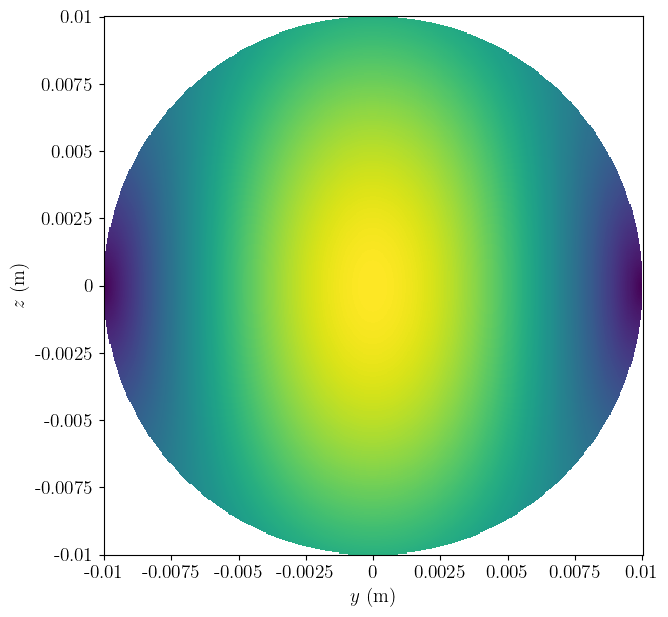

In [32]:
guide_plotter(1, 1, 1e15, 1, 0.01, mode='TE')